<h1> Electric Motor Dataset Analysis </h1>

<p>Introductory analysis for Kaggle <a href="https://www.kaggle.com/wkirgsn/electric-motor-temperature">Electric Motor Temperature</a> dataset. We'll see if we can parse out any useful information in a couple of notebooks and then hopefully create some sort of CLI program eventually.</p>

<p> From the dataset description: </p>
'A comprehensive csv files containing all measurement sessions and features. Each row represents one snapshot of sensor data at a certain time step. Sample rate is 2 Hz (One row per 0.5 seconds). Distinctive sessions are identified with "profile_id".'

<h3> Importing the dataset </h3>
<p>

</p>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

In [2]:
data_df = pd.read_csv(
    'data/pmsm_temperature_data.csv'
)

data_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


<p>
<strong>Thoughts:</strong> We're looking at 2Hz collected data. The first thing I'll try to get a grasp on is which parameters of the engine are being polled by sensors. This will be useful because knowing which sensors are gathering data will orient us to the features that the engineers want to be tracking on this engine, as well as familiarize ourselves with the types of data we'll be seeing.
</p>

<p>
Another thing I'll try to keep track of is when different data collection sessions begin and end and potentially separate those into different data objects.
</p>

In [3]:
columns_list = list(data_df.columns)
num_cols = len(columns_list)

print('Found {} columns in the dataset\n'.format(num_cols))

for feature in columns_list:
    print(feature)

Found 13 columns in the dataset

ambient
coolant
u_d
u_q
motor_speed
torque
i_d
i_q
pm
stator_yoke
stator_tooth
stator_winding
profile_id


<p>
<strong>Thoughts:</strong> Here's what I think each feature of this dataset represents:
</p>

<ul>
    <li><strong>ambient:</strong> The ambient temperature in the room during collection</li>
    <li><strong>coolant:</strong> Temperature of the engine coolant being used, measured at outflow</li>
    <li><strong>u_d:</strong> Voltage D</li>
    <li><strong>u_q:</strong> Voltage Q</li>
    <li><strong>motor_speed:</strong> Speed of the device being driven resulting from current and voltage</li>
    <li><strong>torque:</strong> Torque being generated by the motor</li>
    <li><strong>i_d:</strong> Current D</li>
    <li><strong>i_q:</strong> Current Q</li>
    <li><strong>pm:</strong> Temperature of the magnet</li>
    <li><strong>stator_yoke:</strong> Temperature of stator yoke</li>
    <li><strong>stator_tooth:</strong> Temperature of statoor tooth</li>
    <li><strong>stator_winding:</strong> Temperature of stator winding</li>
    <li><strong>profile_id:</strong> Which session a recording takes place during</li>
</ul>

<p> 
Here's an image that I used to understand roughly what was going on with measurement readings.
</p>
<img src="images/stator_diagram.gif">

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


<p>
<strong>Thoughts:</strong> Looks like every Series we're dealing with is an array of float64 values. This will simplify some of the data munging we might have had to do otherwise.
</p>

<h3> Separating out sessions </h3>

<p>
We heard earlier that the data for this engine is collected in discrete sessions. I want to split the data out so that we can operate on individual sessions at a time.    
</p>

In [5]:
profile_ids = list(data_df['profile_id'].unique())
num_sessions = len(profile_ids)

print('Found {} different measurement sessions within the dataset'.format(num_sessions))

Found 52 different measurement sessions within the dataset


<p>
<strong>Thoughts:</strong> So there are 52 total sessions within this data. n=52 is a pretty great sample size for bench testing. We should have some opportunities for very conclusive data.
</p>

<p>
The next thing I want to do is to split this data into 52 different dataframe objects so that I can operate on just one or many of them individually before coming back for more aggregate analysis between groups.
</p>

In [6]:
session_dfs = []

for sess_ix, session in enumerate(profile_ids):
    session_dfs.append(data_df[data_df['profile_id'] == session])
    
print(
    'Successfully created {} dataframes from the original dataset'
    .format(len(session_dfs))
)

session_dfs[0].head()

Successfully created 52 dataframes from the original dataset


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


<p>
<strong>Thoughts:</strong> We've successfully made a dataframe for each collection session performed. Now that we have these individually parsed out, we should be able to get some interesting information on each session. It might be worthwhile first to just plot some of the metrics from the session over time.
</p>

<p>
Since we're dealing with 2Hz sampling rate, we can create a time axis that informs our analysis in the time domain. Let's write a little function to take information from a single dataframe and plot all of its columns. We'll then run each of the session dataframes through the function. Sorry for any hardcoding but I don't think this notebook will scale 
</p>

In [7]:
def plot_features(df, start_time):
    
    columns = list(df.columns)
    num_cols = len(columns)
    
    plt.figure(figsize=(10,80))
    
    for col_ix, col_name in enumerate(columns[:-1]):
        plt.subplot(num_cols, 1, col_ix+1)
        
        y_values = df[col_name]
        
        time_values = np.arange(start_time, start_time + len(y_values)) / 2
        
        plt.plot(range(start_time, start_time+len(y_values)), y_values)
        plt.title(col_name, fontsize=18)
        plt.ylabel('Sensor reading')
        plt.xlabel('Reading Number')
        
    plt.show()

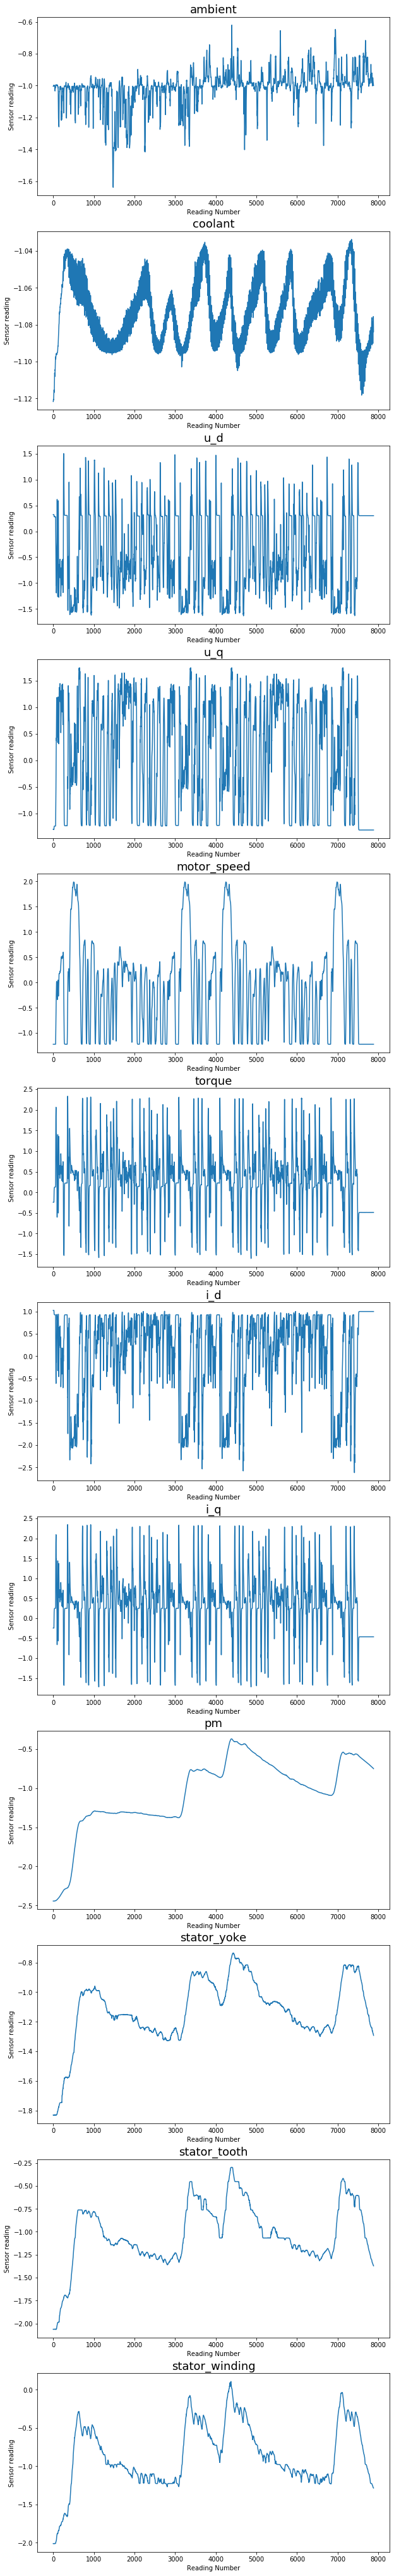

In [8]:
plot_features(session_dfs[3], 0)

<p>
<strong>Thoughts:</strong> These all look great. I'm noticing a couple outlier points that may be hardware errors. I've included a couple of interesting plots that might show outlier data. 
</p>

<p>
Let's inspect that region of the data just to be sure that it's a single point each time, which would constitute noise outside of the device's range. I'll plot some sections that looked explicitly like outliers to me. Let's use a new function that chooses a specific metric to do this to speed up analysis.
</p>

<p>
Sidenote: since indices are just integers we shouldn't have to use iloc or loc to get the value range we want.
</p>

In [9]:
def plot_single_feature(df, start_time, col_name):
    
    columns = list(df.columns)
    num_cols = len(columns)
    
    plt.figure(figsize=(10,10))
    
    y_values = df[col_name]

    time_values = np.arange(start_time, start_time + len(y_values)) / 2

    plt.plot(range(start_time, start_time+len(y_values)), y_values)
    plt.title(col_name, fontsize=18)
    plt.ylabel('Sensor Reading Value')
    plt.xlabel('Reading Number')
        
    plt.show()

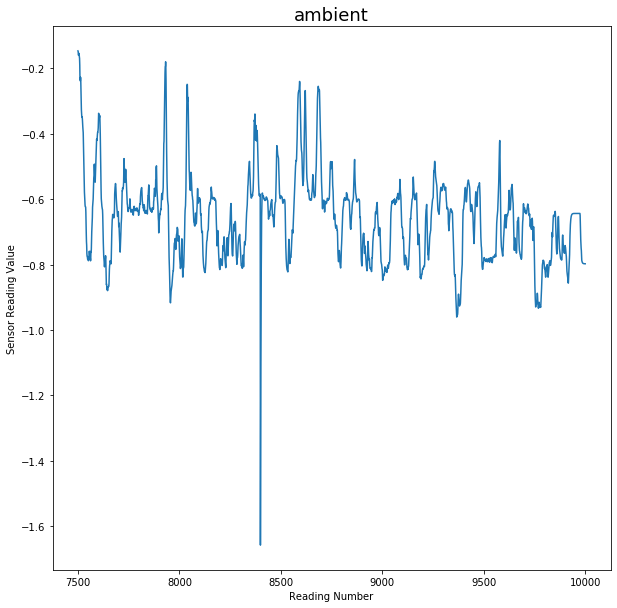

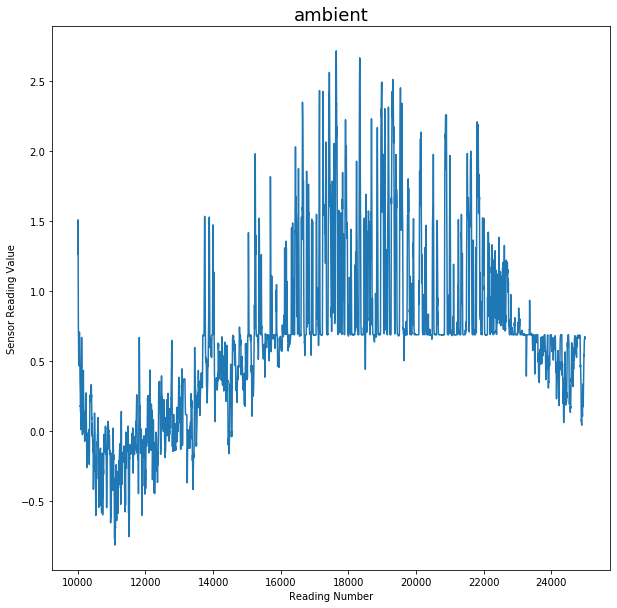

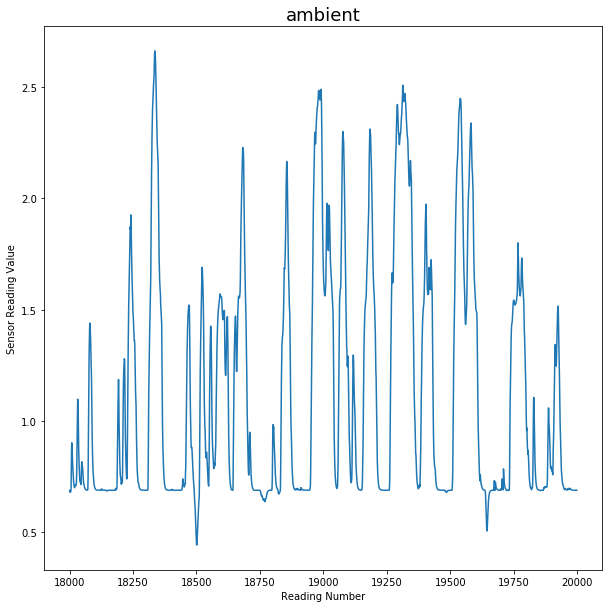

In [10]:
outliers_df_0 = session_dfs[0][7500:10000]
plot_single_feature(outliers_df_0, 7500, 'ambient')

outliers_df_1 = session_dfs[1][10000:25000]
plot_single_feature(outliers_df_1, 10000, 'ambient')

outliers_df_2 = session_dfs[1][18000:20000]
plot_single_feature(outliers_df_2, 18000, 'ambient')

<p>
<strong>Thoughts:</strong> It's definitely looking like the dataset has some noise beyond the limits of the sensors. We can see pretty clear trends occurring within the data that are interrupted by single points a few times throughout the dataset. However, I don't want to get rid of them immediately. Using an averaging filter might get rid of the points we're noticing that are regional outliers, but in general there are enough data points outside of the apparent sensor range that they significantly affect the average and I don't want to remove them. The best way to solve this would be a smoothing filter to remove sharp immediate spikes, but I think we can just hold onto them for now.
</p>

<p>
Let's get some descriptive statistics to determine what might actually be considered erroneous outliers.
</p>

In [11]:
print('==DESCRIPTIVE STATISTICS==')
print(data_df.describe())

print('\n')

print('==OUTLIER FINDING==')
print(data_df.quantile(0.99))

==DESCRIPTIVE STATISTICS==
             ambient        coolant            u_d            u_q  \
count  998070.000000  998070.000000  998070.000000  998070.000000   
mean       -0.003905       0.004723       0.004780      -0.005690   
std         0.993127       1.002423       0.997878       1.002330   
min        -8.573954      -1.429349      -1.655373      -1.861463   
25%        -0.599385      -1.037925      -0.826359      -0.927390   
50%         0.266157      -0.177187       0.267542      -0.099818   
75%         0.686675       0.650709       0.358491       0.852625   
max         2.967117       2.649032       2.274734       1.793498   

         motor_speed         torque            i_d            i_q  \
count  998070.000000  998070.000000  998070.000000  998070.000000   
mean       -0.006336      -0.003333       0.006043      -0.003194   
std         1.001229       0.997907       0.998994       0.997912   
min        -1.371529      -3.345953      -3.245874      -3.341639   
25%   

<p>
<strong>Thoughts:</strong> None of the max values are such that I'm comfortable striking large swaths from the data. We'll see as we analyze what issues might come up.
</p>

<p>
The next two routes I want to pursue are checking differences between the temperature magnitude signals in time and the spectral content of the signals.
</p>

<p>
The spectral content may give us an idea of what sort of periodic behavior is occurring within the engine, whether that's a natural cooling cycle, or otherwise some sort of errant harmonic behavior.
</p>

<p>
By comparing the magnitudes over time I'm hopeing to determine which sections of the engine might show independent heating. This would be a cause for further analysis of that section of the engine and might be able to narrow the focus of the tasked engineers so they can perform further thermodynamic testing on that section of the engine. Ideally we might be able to see which sections of the engine consistently run at higher temperatures.
</p>

In [86]:
def show_fourier(df, col_name, max_f=10000):
    session_fft = np.fft.rfft(df[col_name])[5:max_f]
    
    plt.figure(figsize=(10,10))
    
    plt.plot(session_fft)
    
    plt.title('{} Fourier Transform'.format(col_name.upper()), fontsize=18)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    
    plt.show()

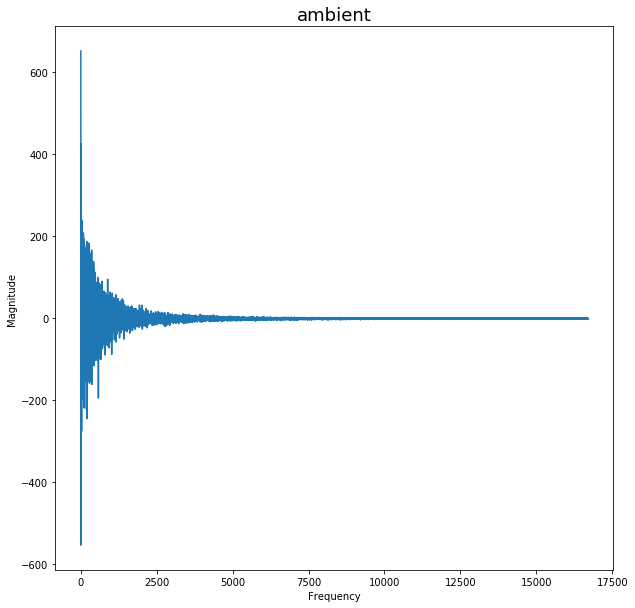

In [37]:
show_fourier(session_dfs[0], 'ambient')

<p>
<strong>Thoughts:</strong> So it looks like most of the temperature differences are on a very low frequency order. That makes sense for ambient temperature. Let's try some other features.
</p>

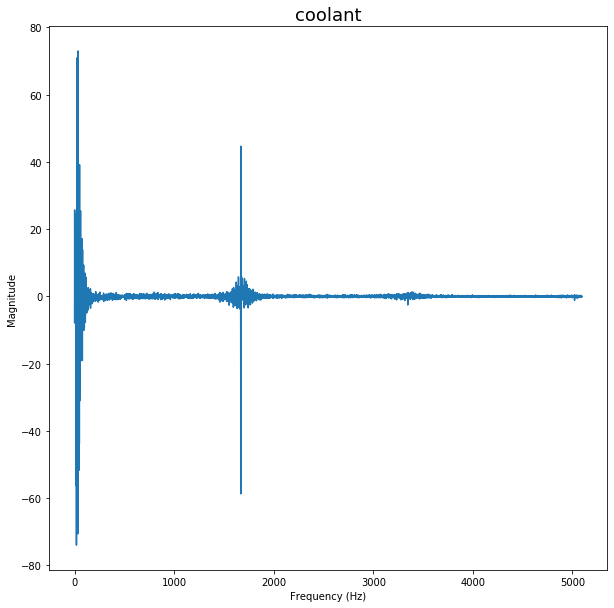

In [55]:
show_fourier(session_dfs[0], 'coolant', 5100)

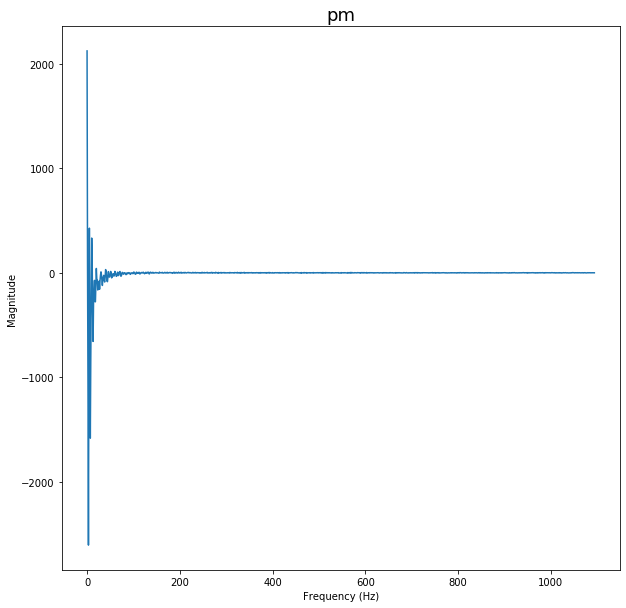

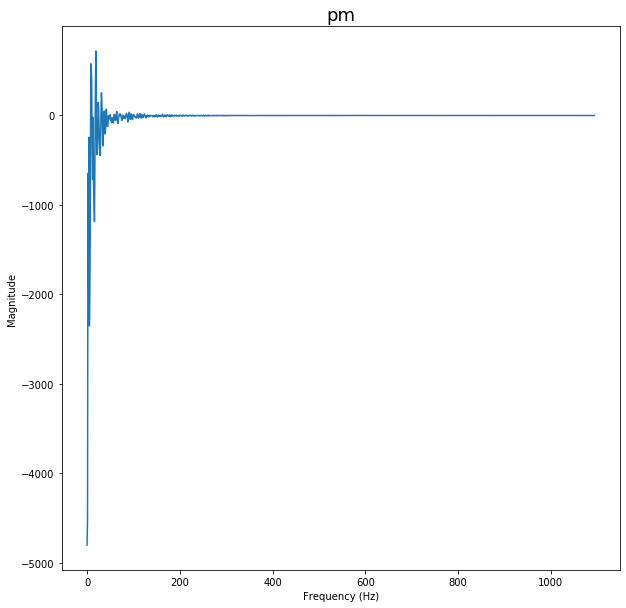

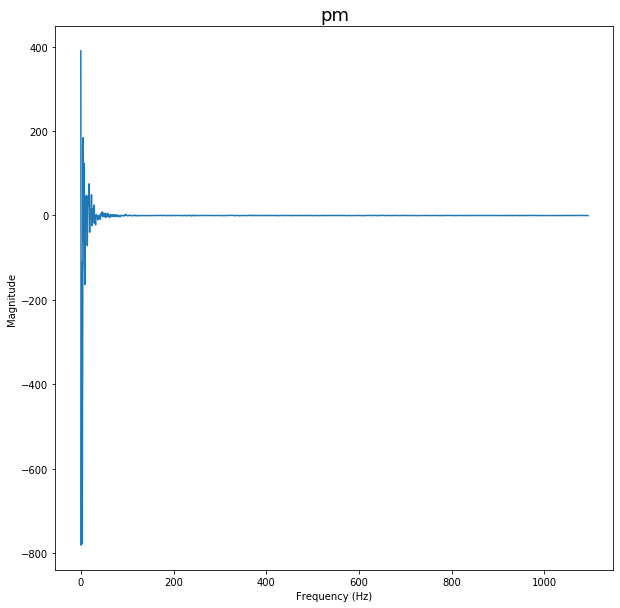

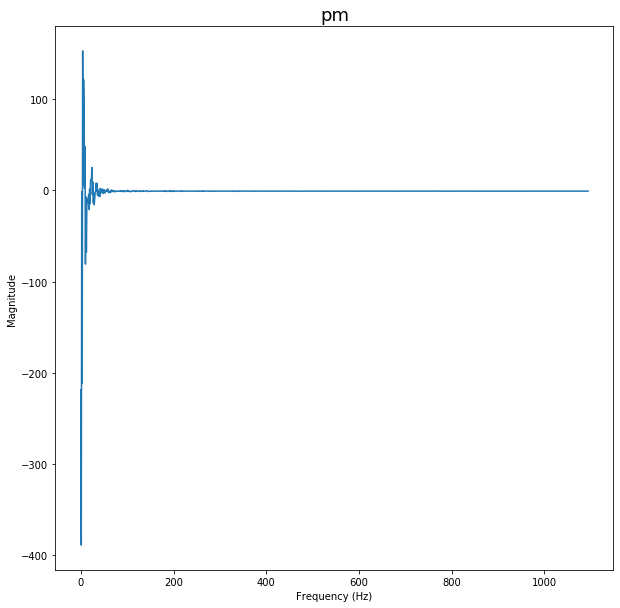

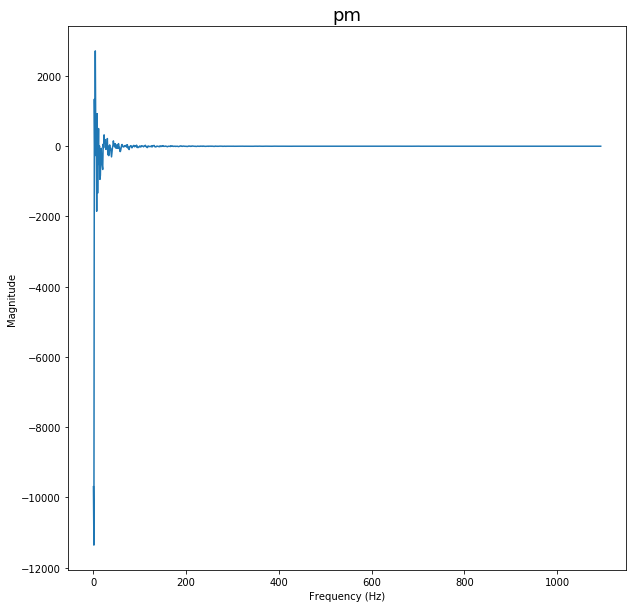

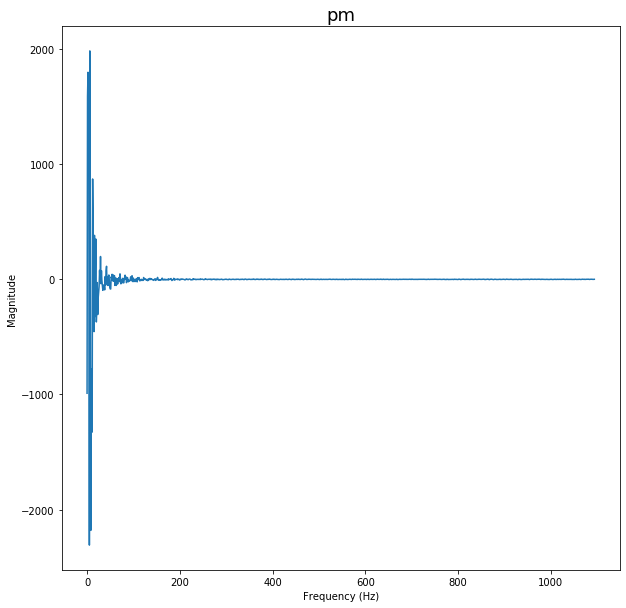

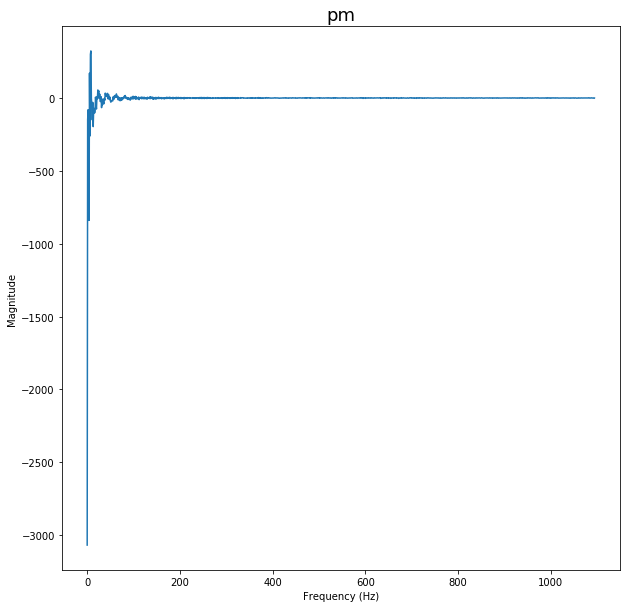

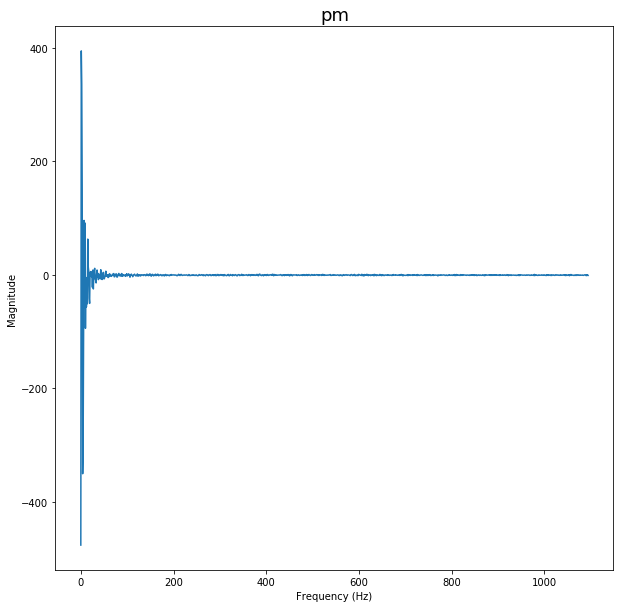

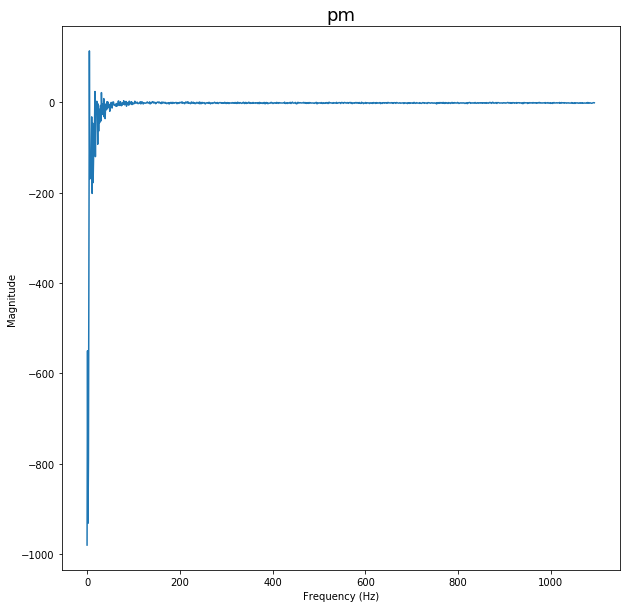

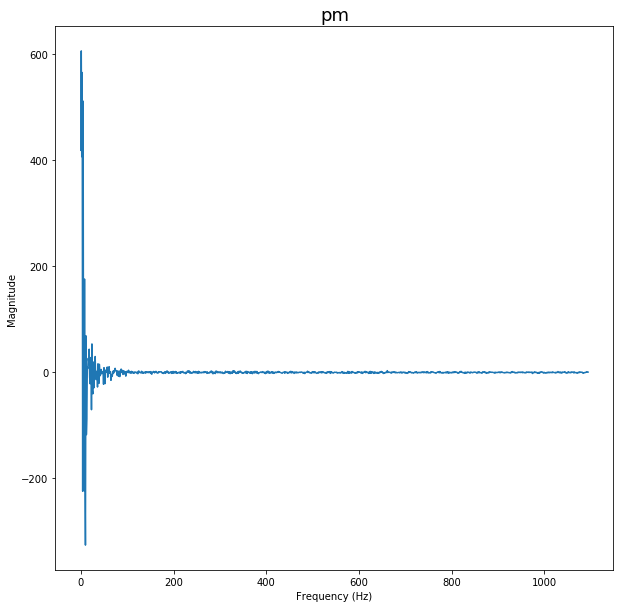

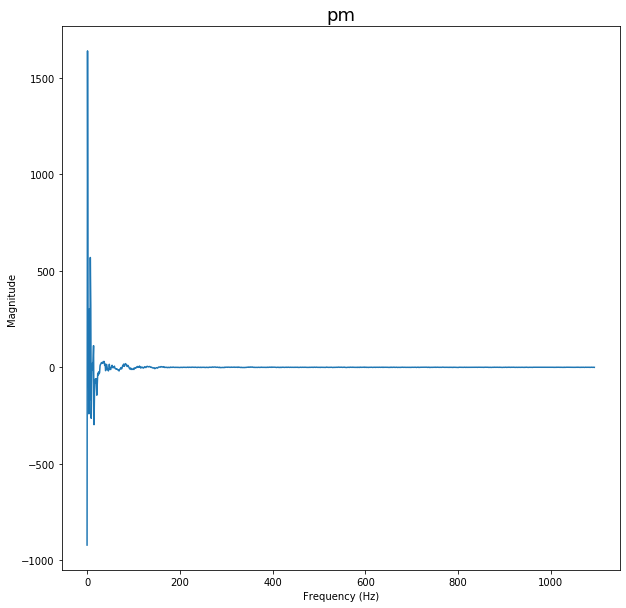

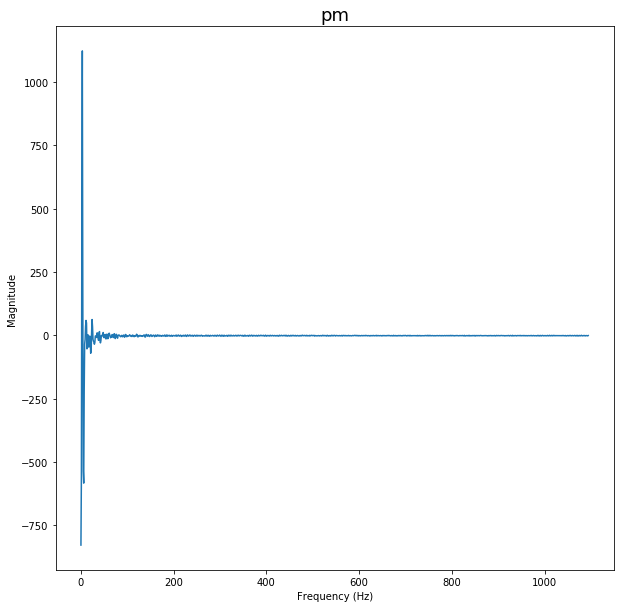

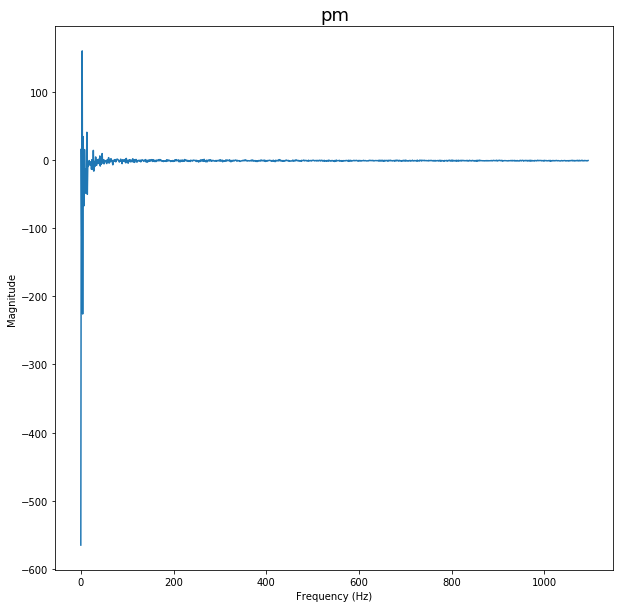

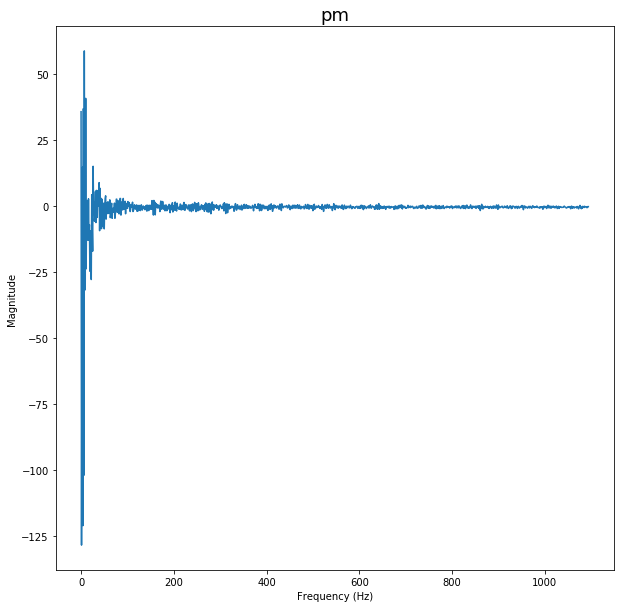

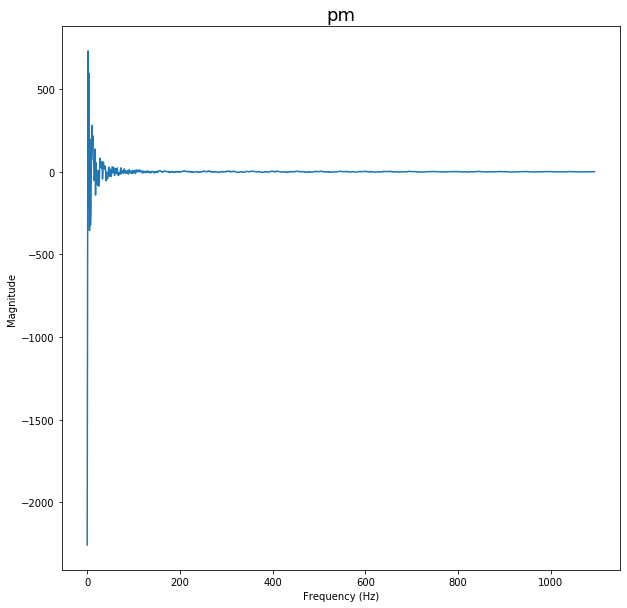

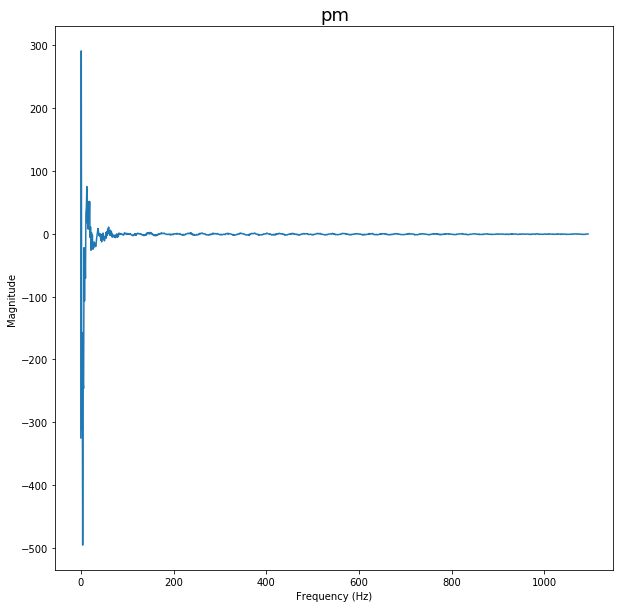

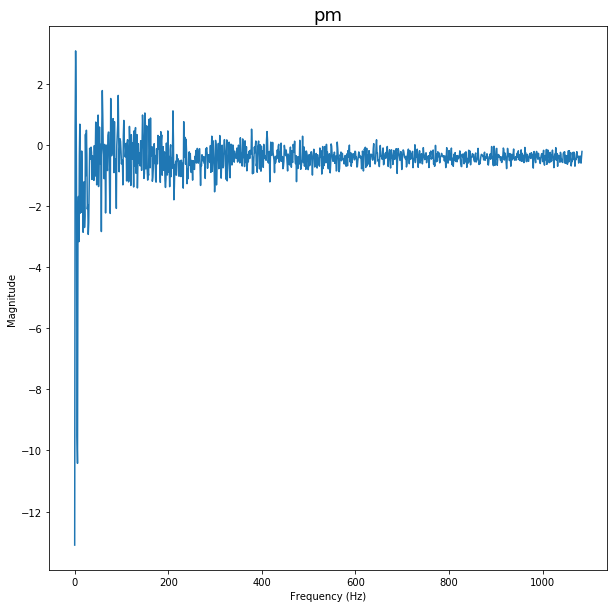

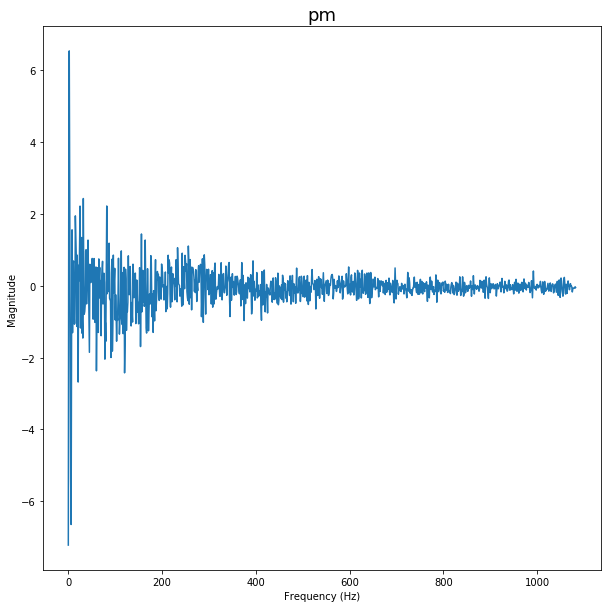

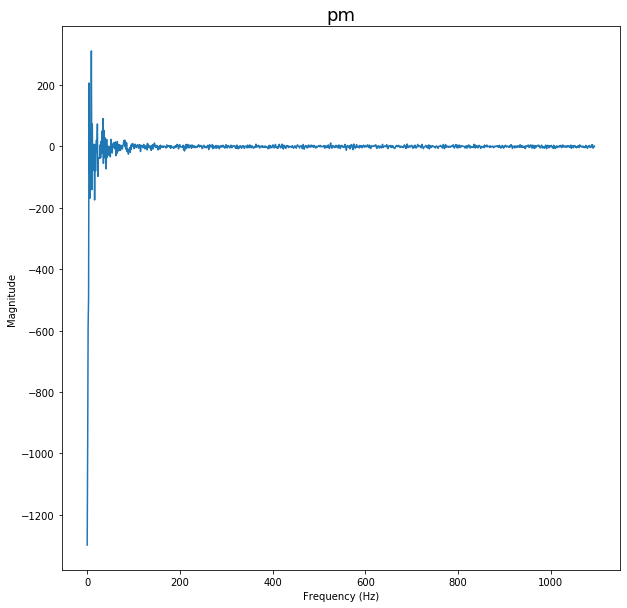

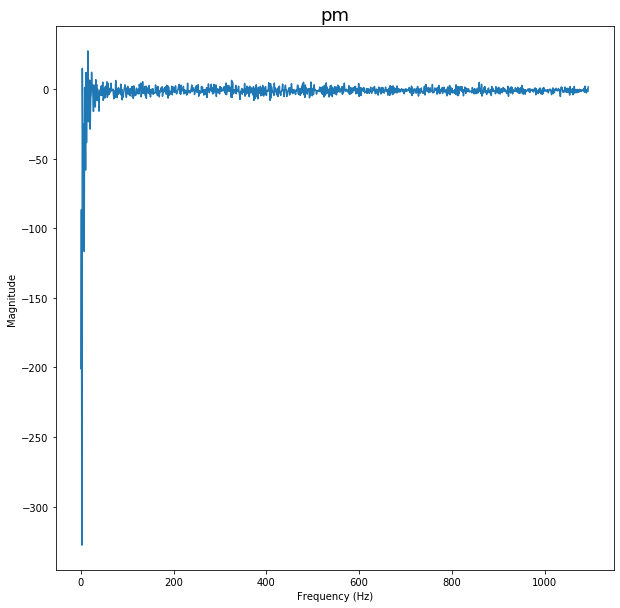

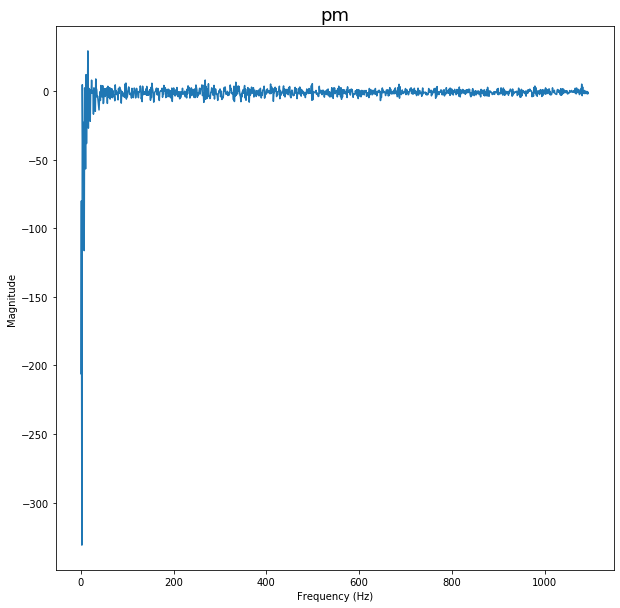

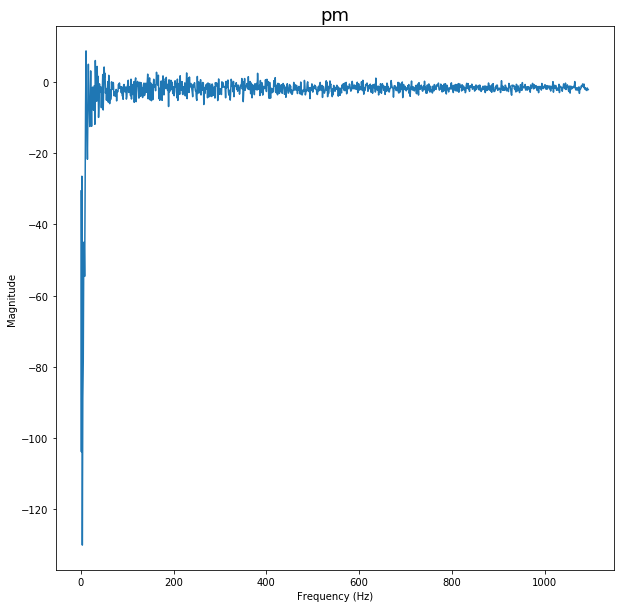

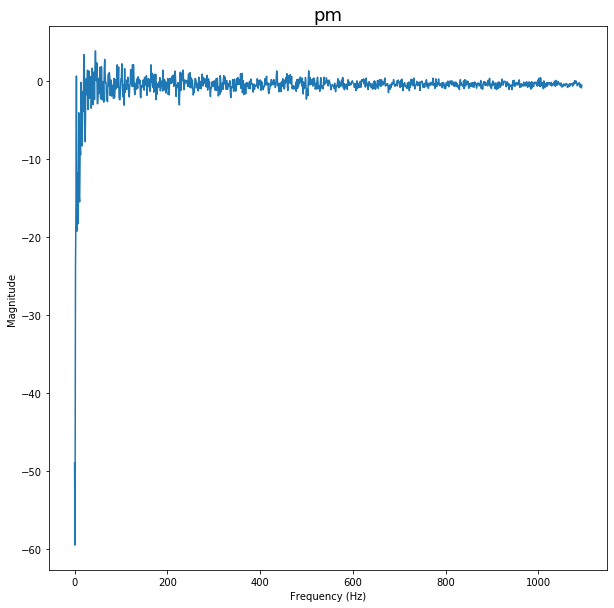

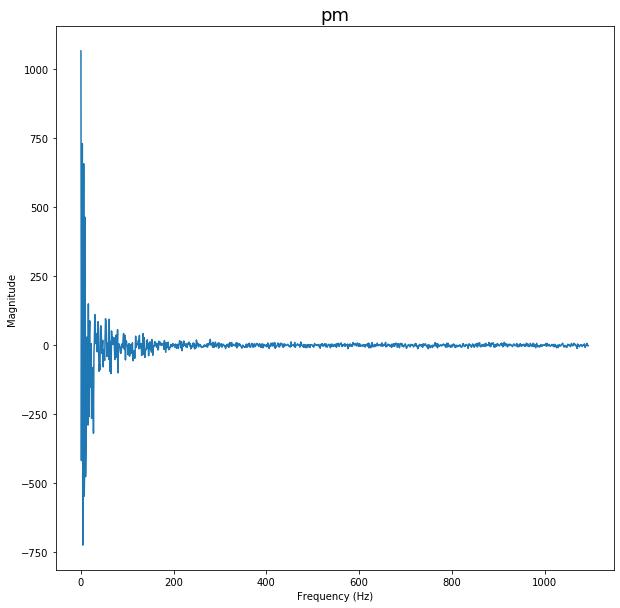

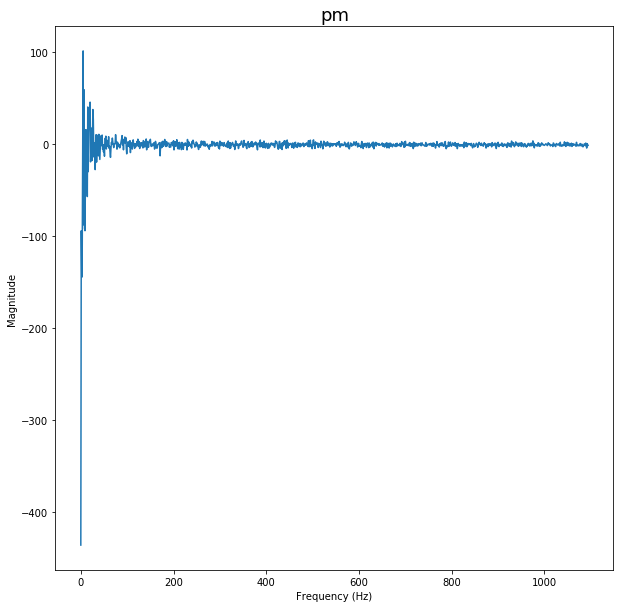

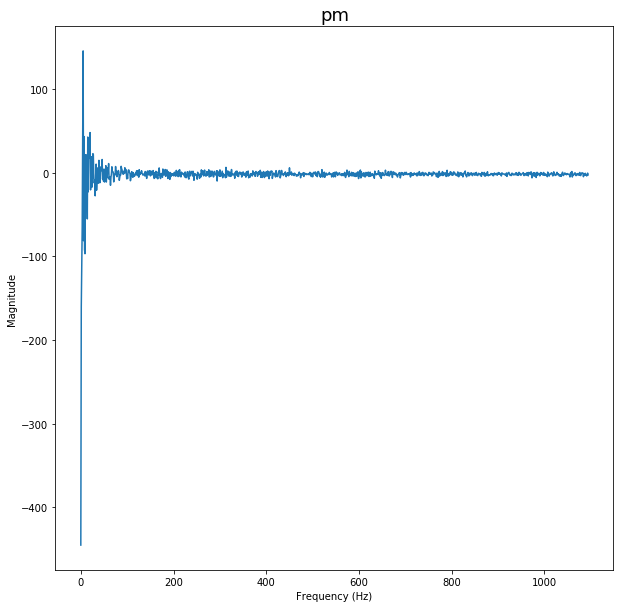

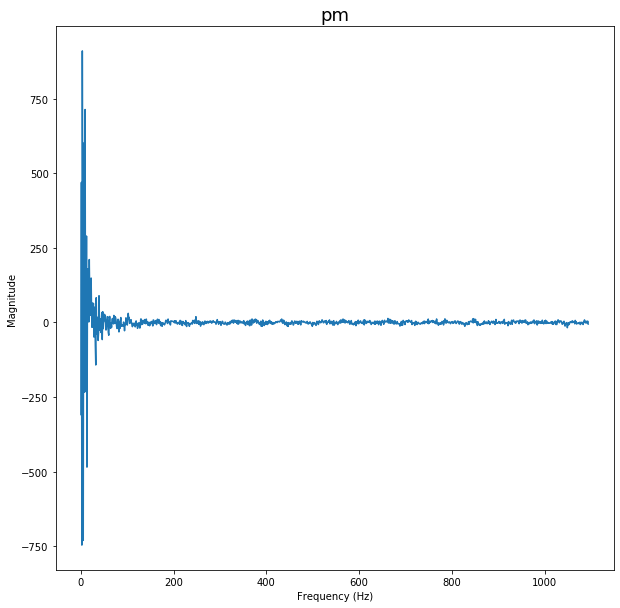

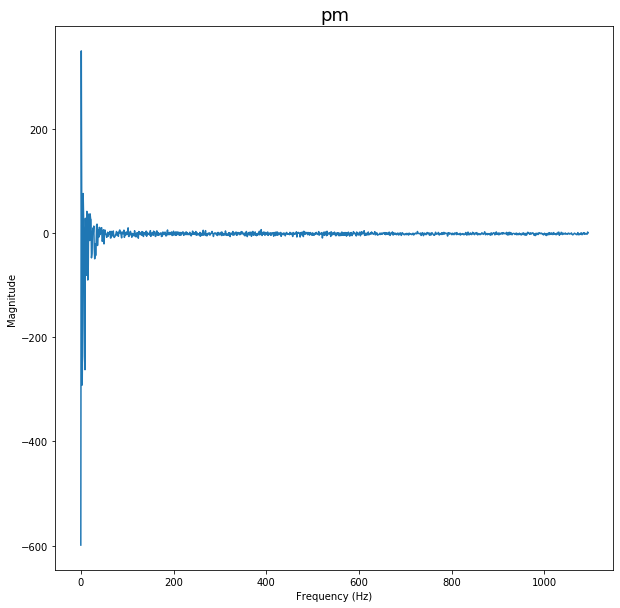

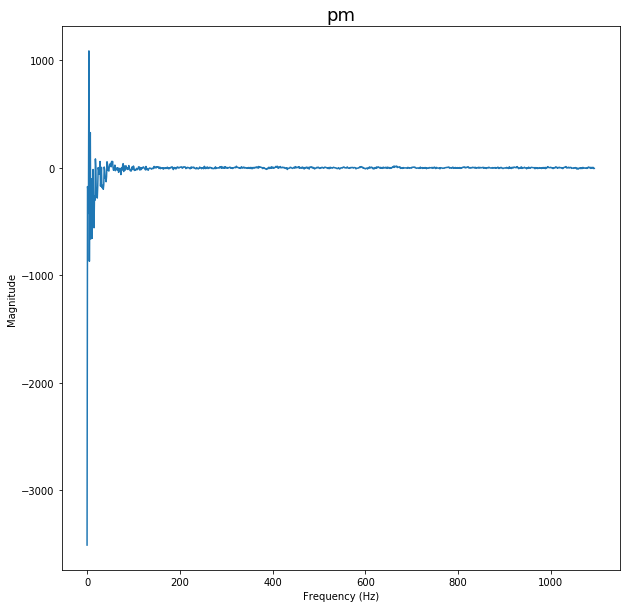

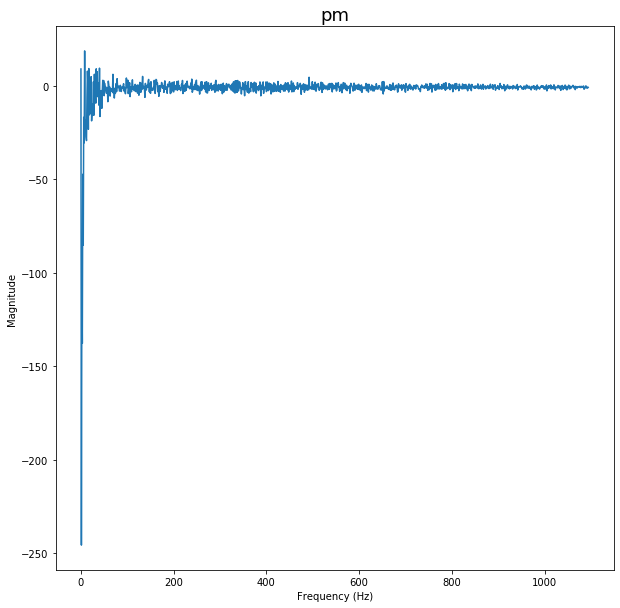

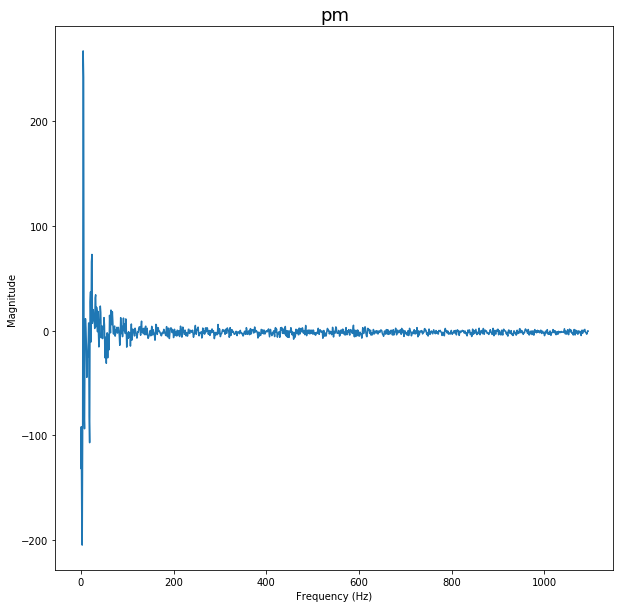

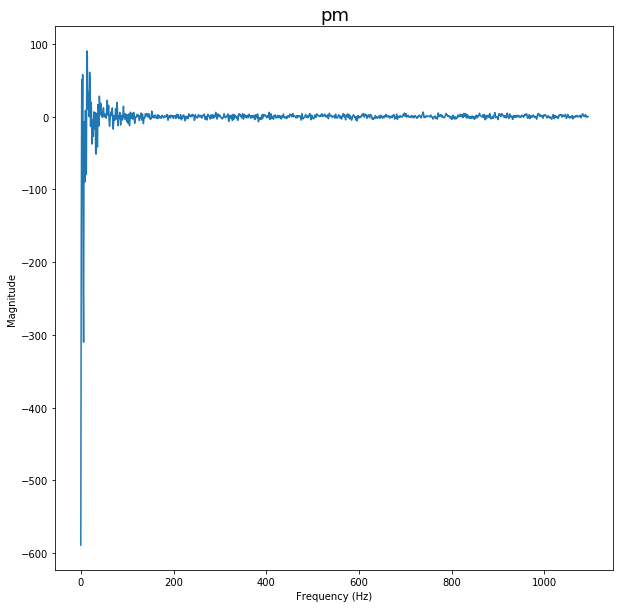

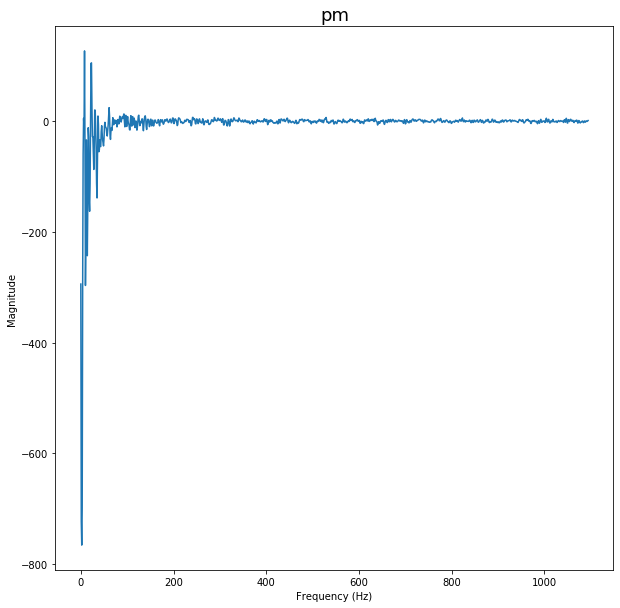

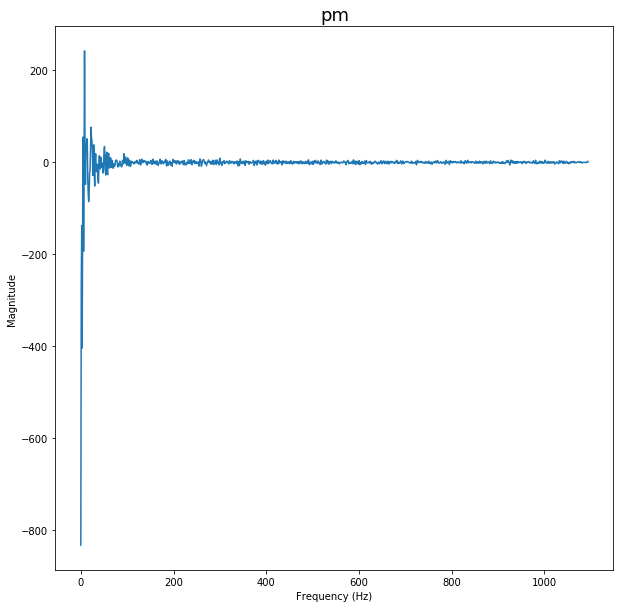

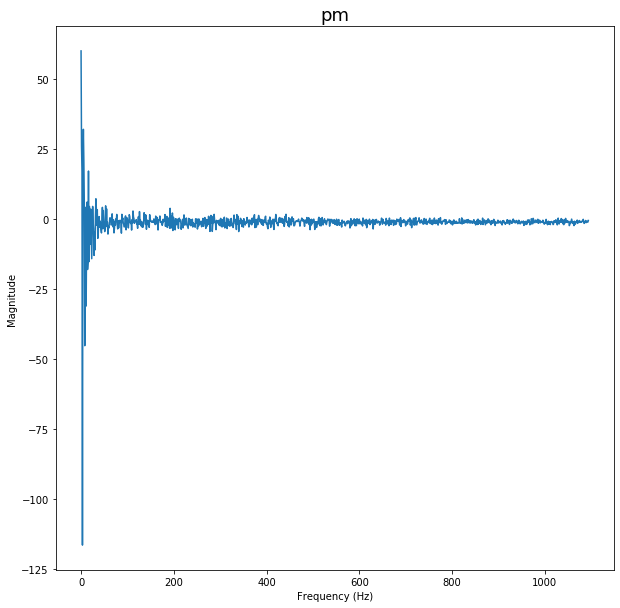

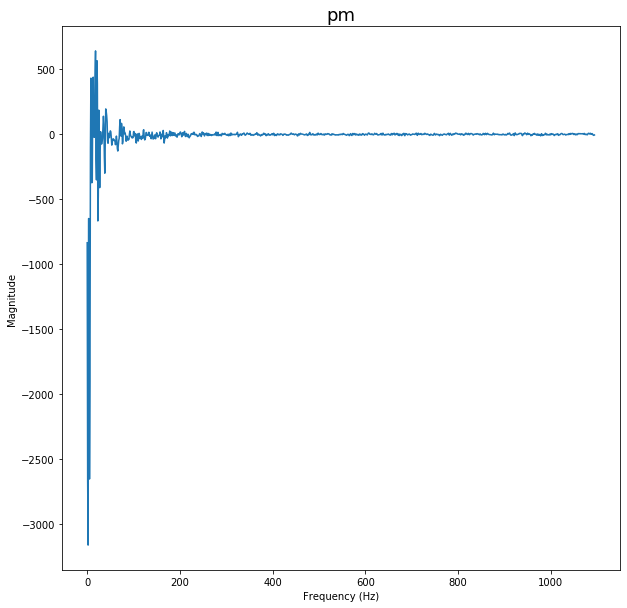

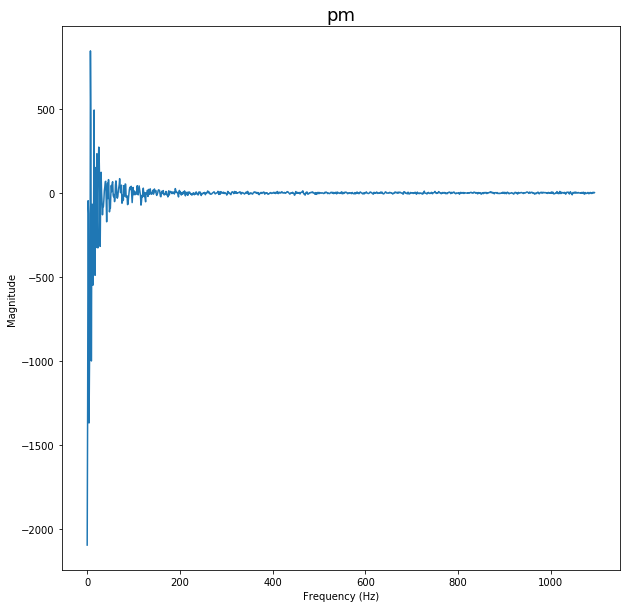

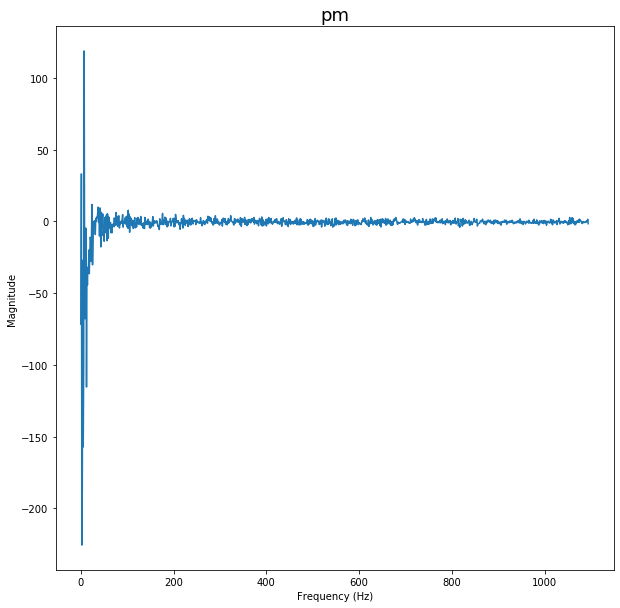

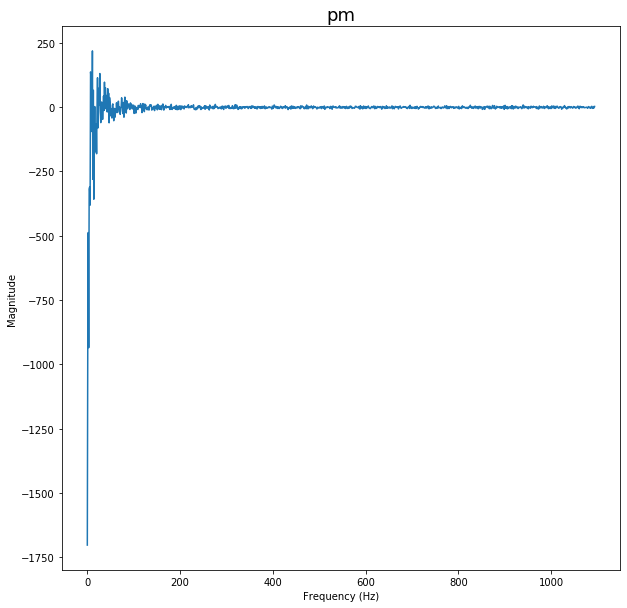

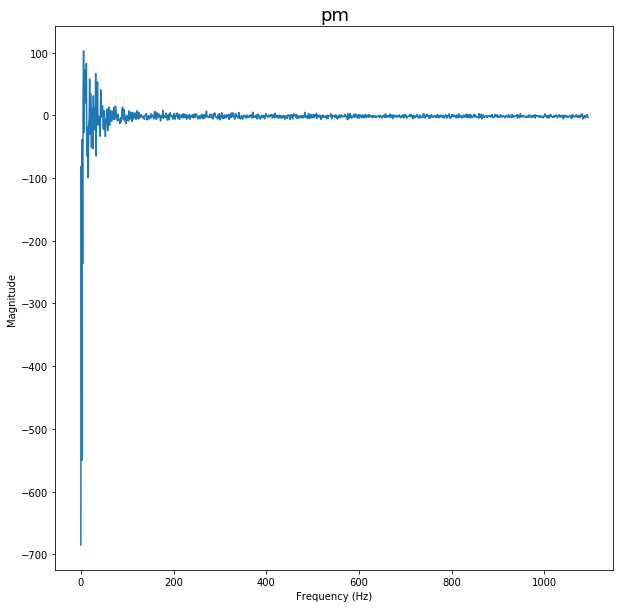

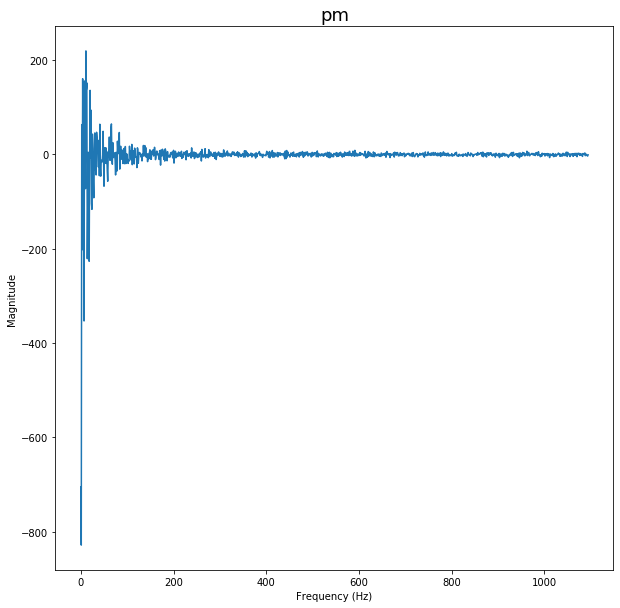

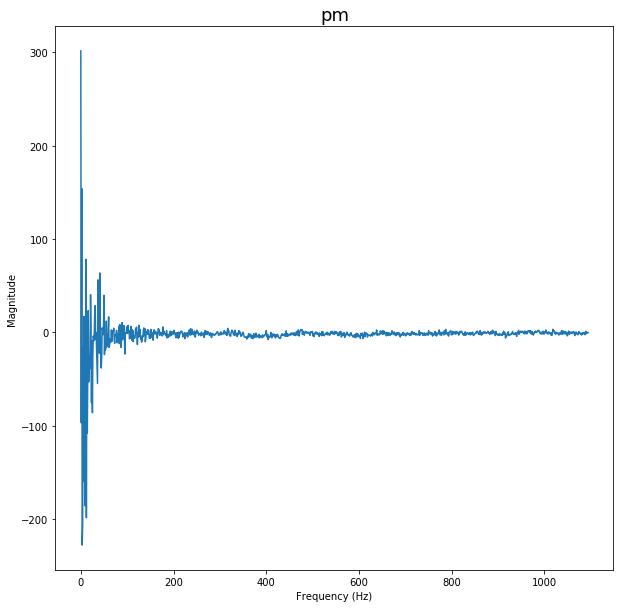

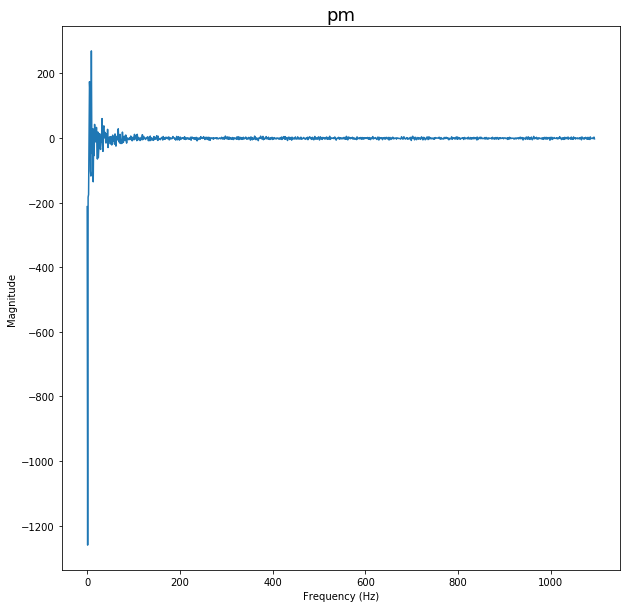

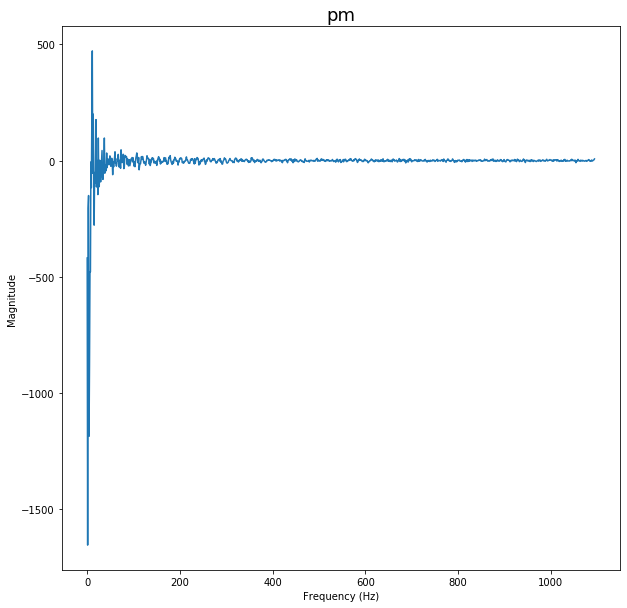

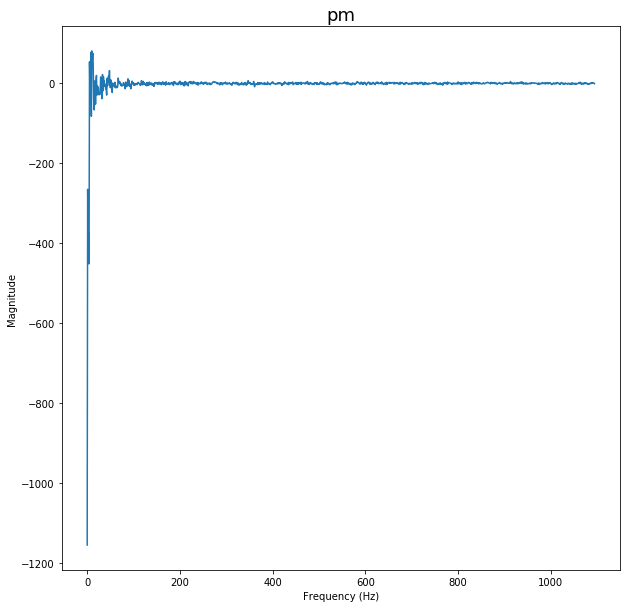

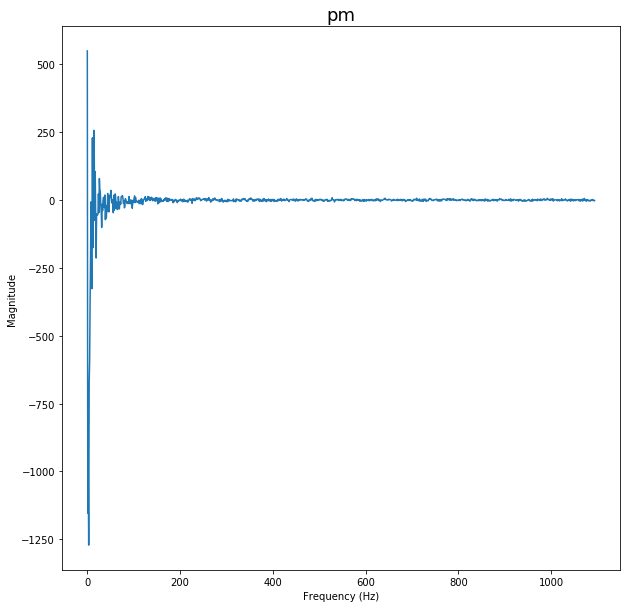

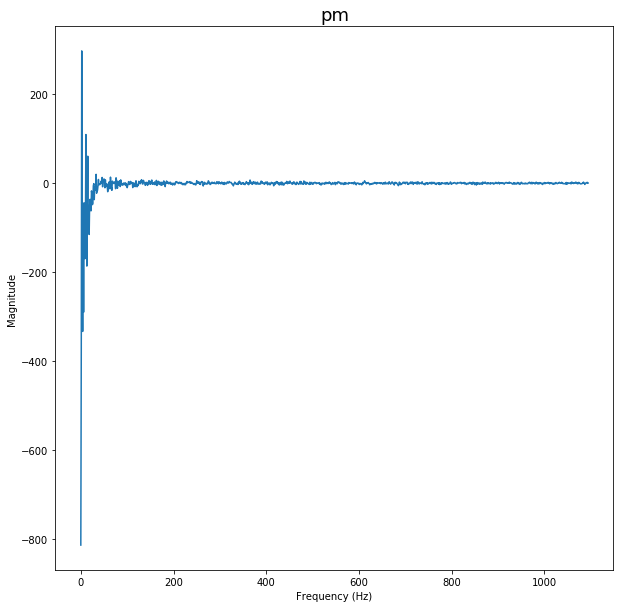

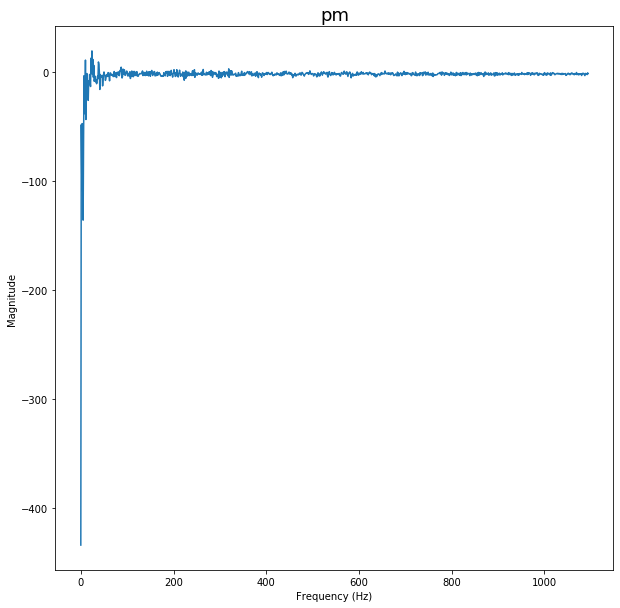

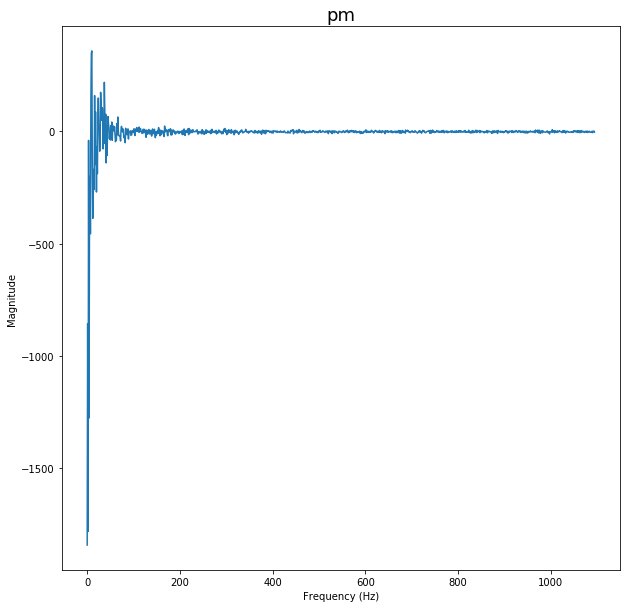

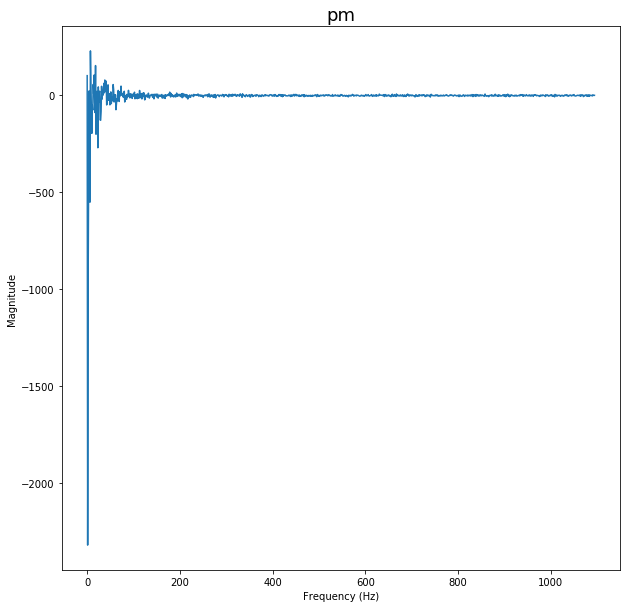

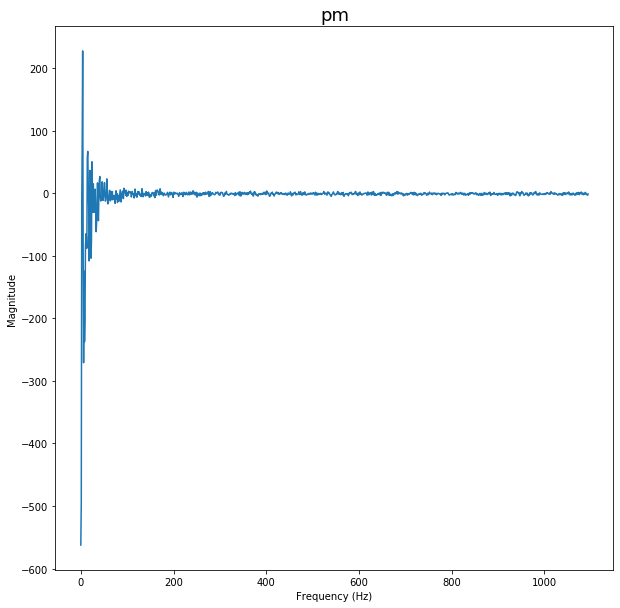

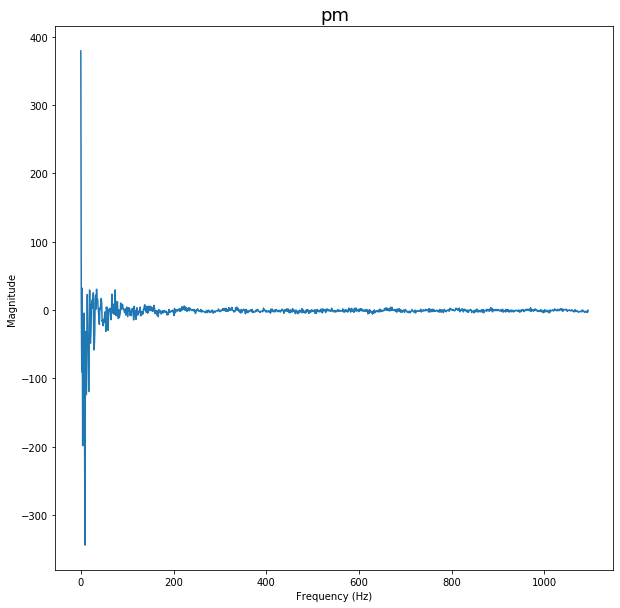

In [64]:
target_feature = 'pm'
for i in range(num_sessions):
    show_fourier(session_dfs[i], target_feature, 1100)

<p>
<strong>Thoughts:</strong> I'm not seeing any immediately interesting frequency results anywhere except in the coolant temperature reading. We're seeing some explicitly periodic behavior on that monitor at frequencies ~1750Hz, ~3100Hz, and arguably right at about 5000Hz.
</p>

<p>
That's certainly an interesting find. I'm not sure what might be causing the temperature to behave so periodically for that coolant (possibly fluid mechanics with the outflow), but I think it would certainly be worth questioning a benchtop engineer about to get some insight into their testing methods.
</p>

<p>
Just to sate my curiosity I want to run a couple of other frequency domain tests just to see if there's anything fun going on.
</p>

In [91]:
def show_power_spectrum(df, col_name, max_f=10000):
    fs = 2
    
    f, Pxx = signal.periodogram(df[col_name], fs)
    f   =   f[5:max_f] * max_f
    Pxx = Pxx[5:max_f]
    
    plt.figure(figsize=(10,10))
        
    plt.title('{} Power Spectral Density'.format(col_name.upper()), fontsize=18)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V**2/Hz)')
    plt.semilogy(f, Pxx)
    
    plt.show()

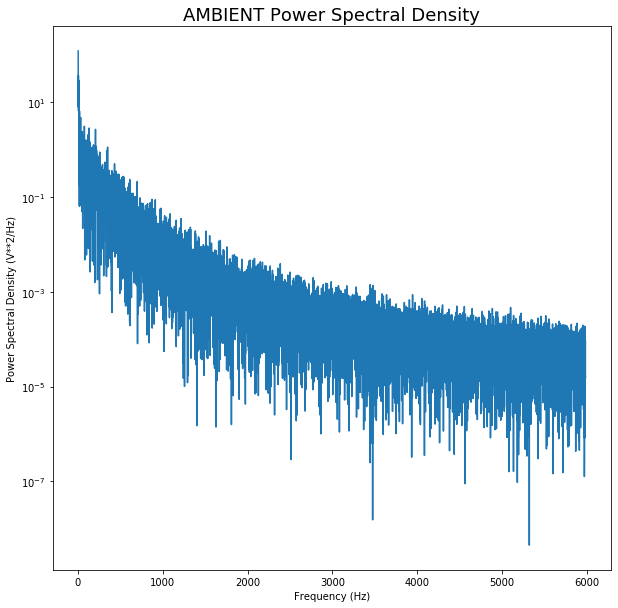

In [92]:
show_power_spectrum(session_dfs[0], 'ambient')

<p>
<strong>Thoughts:</strong> Alright I'm bored of the frequency domain. I may come back to if if time domain features are a bit sparse (and also to investigate that coolant periodicity finding), but for now I'm gonna move back to the time domain and check out if there's any information to be gleaned about which portion of the engine gets the hottest.
</p>

<p>
Let's start basic and just check out the graphs of each temperature reading stacked on top of each other with a function.
</p>

In [122]:
def plot_temps(df, start_time=0):
    
    y_values = df['ambient'][start_time:]
    
    plt.figure(figsize=(10,10))
    plt.plot(range(start_time, start_time+len(y_values)), y_values)
    plt.title('AMBIENT Sensor Readings', fontsize=18)
    plt.ylabel('Sensor Reading Value')
    plt.xlabel('Reading Number')
    
    y_values = df['coolant'][start_time:]
    
    plt.figure(figsize=(10,10))
    plt.plot(range(start_time, start_time+len(y_values)), y_values)
    plt.title('COOLANT Sensor Readings', fontsize=18)
    plt.ylabel('Sensor Reading Value')
    plt.xlabel('Reading Number')

    stator_names = [
        'pm',
        'stator_yoke',
        'stator_tooth',
        'stator_winding'
    ]
    
    plt.figure(figsize=(10,10))
    plt.title('STATOR Sensor Readings', fontsize=18)
    plt.ylabel('Sensor Reading Value')
    plt.xlabel('Reading Number')
    
    for temp_ix, col_name in enumerate(stator_names):
        y_values = df[col_name]
        plt.plot(range(start_time, start_time+len(y_values)), y_values)
        
    plt.legend(stator_names)
    
    plt.show()

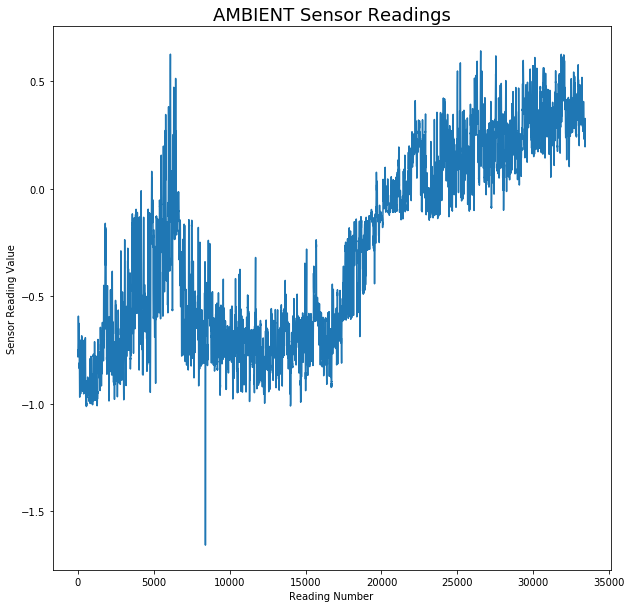

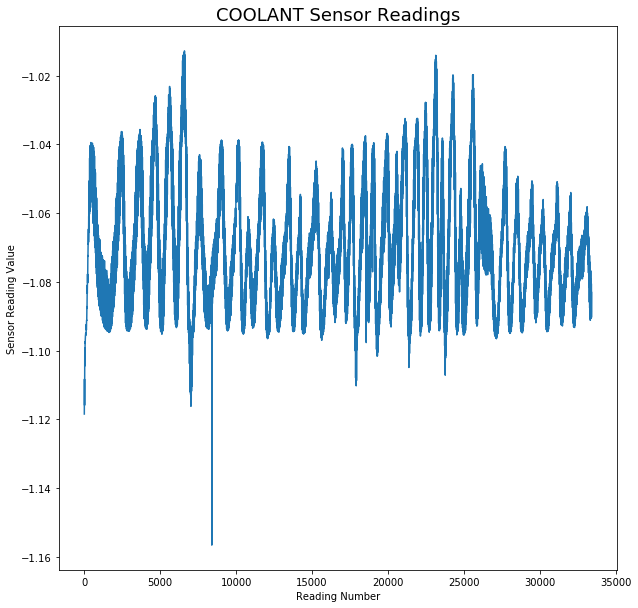

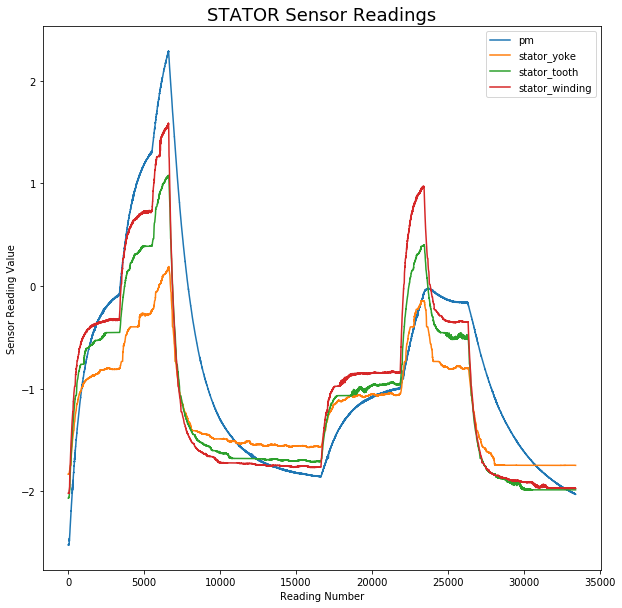

In [123]:
plot_temps(session_dfs[0])

<p>
<strong>Thoughts:</strong> Looks like we've got a pretty hot magnet. I'm not able to comment on too much else, because I don't know the design of the motor very well, but I think some inferences could definitely be made about the thermodynamic properties of the motor here based on proximity and the similar heating patterns displayed here.
</p>

<p>
Some immediate things that jump out to me are the slow rise in temperature for the actual permanent magnet surface itself. It might have a higher thermal coefficient or a less heat-conducive material than the rest of the motor since it retains its temperature quite well.
</p>

<p>
I'd like to start seeing if we can make some correlations so let's write another function very similar to the last, but let's add the motor speed and torque plots below the temperature plots to see the correlation there.
</p>

In [139]:
def plot_speed_temps(df, start_time=0):

    stator_names = [
        'pm',
        'stator_yoke',
        'stator_tooth',
        'stator_winding',
        'motor_speed'
    ]
    
    fig, ax = plt.subplots(3, 1, sharex='col', figsize=(10,10))
    #fig = plt.figure(figsize=(10,10))
    plt.suptitle('Motor Output Effects on Temp', fontsize=18)
    plt.ylabel('Sensor Reading Value')
    plt.xlabel('Reading Number')
    
    fig.add_subplot(3,1,1)
    for temp_ix, col_name in enumerate(stator_names[0:3]):
        y_values = df[col_name]
        plt.plot(range(start_time, start_time+len(y_values)), y_values)
        
    plt.legend(stator_names)
    
    fig.add_subplot(3,1,2)
    y_values = df['motor_speed']
    plt.plot(range(start_time, start_time+len(y_values)), y_values)
    
    fig.add_subplot(3,1,3)
    y_values = df['torque']
    plt.plot(range(start_time, start_time+len(y_values)), y_values)
    
    plt.show()

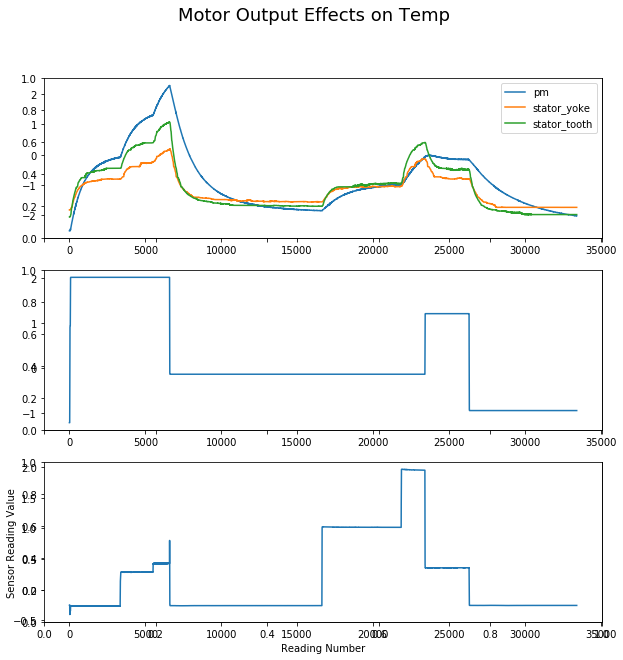

In [140]:
plot_speed_temps(session_dfs[0])